In [1]:
import pickle
from diffusion.sampling import *
from diffusion.likelihood import mmff_energy
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True 
import py3Dmol
from rdkit import Chem 
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolAlign
from termcolor import colored
from rdkit.Chem import rdMolTransforms

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torchani/aev.py:

## Optimizing structures

In [2]:
# load conformers_20steps.pkl
conformers = pickle.load(open('conformers_20steps_boltz_T1000.pkl', 'rb'))
conformers_optimized = pickle.load(open('conformers_20steps_optimized_boltz_T1000.pkl', 'rb'))
smis = list(conformers.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'conformers_20steps_boltz_T1000.pkl'

In [3]:

from utils.standardization import *
def get_rmsds(mols, mols_optimized):
    rmsds = []
    for conf_idx in range(len(mols)):
        rmsds.append(fast_rmsd(mols[conf_idx], mols_optimized[conf_idx], conf1=0, conf2=0) )
    return rmsds

In [2]:

for i, smile in enumerate(smis): 
    #Plt figure with 2 subfigures
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    mols = conformers[smile]
    mols_optimized = conformers_optimized[smile]
    #Plot the hists in the first subfigure
    ax[0].hist([mmff_energy(mol) for mol in mols], bins=20, color = 'blue', label='before optimization', alpha=0.25,  )
    ax[0].hist([mmff_energy(mol) for mol in mols_optimized], bins=20, color = 'orange',label='after optimization', alpha=0.25)
    ax[0].legend()
    ax[0].set_xscale('log')
    ax[0].set_title(f'Energy distribution')
    # Plot the RMSD in the second subfigure
    rmsds = get_rmsds(mols, mols_optimized)
    ax[1].boxplot(rmsds)
    ax[1].set_title(f'RMSD(unoptimized, optimized)')
    #Add title for the whole figure
    i+=1
    #if i ==1:
        #break


NameError: name 'smis' is not defined

### Comparing structures before and after optimization

In [13]:
conf_idx =3
print('RMSD',fast_rmsd(mols[conf_idx], mols_optimized[conf_idx], conf1=0, conf2=0) )

mol1, mol2 =mols[conf_idx], mols_optimized[conf_idx]
rdMolAlign.AlignMol(mol1, mol2)

# Convert to mol blocks
mol1_block = Chem.MolToMolBlock(mol1)
#mol2_block = Chem.MolToMolBlock(mol2)

view = py3Dmol.view(width=400, height=400)
view.addModel(mol1_block, "mol")
#view.addModel(mol2_block, "mol")
view.setStyle({'model': 0}, {'stick': {'color': 'red'}})
#view.setStyle({'model': 1}, {'stick': {'color': 'blue'}})
view.addLabel('Before (red) vs after (bue) optimization}',{'position': {'x': 0, 'y': 8, 'z': 0}, 
               'backgroundColor': 'white', 
               'fontColor': 'black', 
               'fontSize': 16, 
               'alignment': 'topCenter'})

for i in range(mol1.GetNumAtoms()):
    atom = mol1.GetAtomWithIdx(i)
    pos = mol1.GetConformer().GetAtomPosition(i)
    view.addLabel(str(i), {'position': {'x': pos.x, 'y': pos.y, 'z': pos.z},
                           'backgroundColor': 'lightgray',
                           'fontColor': 'black',
                           'fontSize': 14})

view.zoomTo()

# Show the viewer
view.show()

RMSD 1.6411845939662062


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [54]:
def get_bond_lengths(mol):
    assert mol.GetNumConformers() == 1
    bond_lengths = []
    for bond in mol.GetBonds():
        bond_lengths.append(rdMolTransforms.GetBondLength(mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() ) )
    return torch.Tensor(bond_lengths)

def get_bond_angles(mol):
    assert mol.GetNumConformers() == 1
    bond_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                angle = rdMolTransforms.GetAngleRad(mol.GetConformer(),   
                                                    atom1.GetIdx(), 
                                                    atom2.GetIdx(), 
                                                    neighbor.GetIdx())
                        
                #print(f"Angle {atom1.GetSymbol()}-{atom2.GetSymbol()}-{neighbor.GetSymbol()}: {angle:.2f} rad")
                bond_angles.append(angle)

    return torch.Tensor(bond_angles)

def get_torsion_angles(mol):
    assert mol.GetNumConformers() == 1
    torsion_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor1 in atom2.GetNeighbors():
            if neighbor1.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                for neighbor2 in neighbor1.GetNeighbors():
                    if neighbor2.GetIdx() != atom2.GetIdx() and neighbor2.GetIdx() != atom1.GetIdx():
                        torsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(), 
                                                                 atom1.GetIdx(), 
                                                                 atom2.GetIdx(), 
                                                                 neighbor1.GetIdx(), 
                                                                 neighbor2.GetIdx())
                        torsion_angles.append(torsion)
    return torch.Tensor(torsion_angles)

In [56]:
get_torsion_angles(mol1), get_torsion_angles(mol2)

(tensor([-3.0545e+00, -8.9941e-01,  1.0978e+00, -5.8763e-01, -1.0949e+00,
          2.0466e+00,  3.1416e+00,  1.9544e-04, -3.1416e+00, -1.7290e-04,
         -1.3436e-05, -3.1416e+00,  4.2157e-07, -3.1416e+00,  1.8024e-06,
         -3.1416e+00, -3.1414e+00,  9.3572e-06,  1.0628e+00, -2.0788e+00,
         -3.1416e+00, -2.1980e-05,  3.7189e-01, -2.8267e-01,  2.8589e+00,
         -2.3718e+00,  7.6981e-01, -1.6736e+00,  2.5445e+00,  5.2011e-01,
         -8.3763e-01,  2.3040e+00, -3.1415e+00,  5.3986e-05,  3.1415e+00,
         -4.8116e-05, -8.8955e-06, -3.1416e+00,  1.4198e-05,  3.1416e+00,
         -1.2781e-05,  3.1416e+00,  6.9404e-06,  3.1416e+00,  3.1415e+00,
         -2.5880e-06,  2.0466e+00,  2.3636e-05, -3.1413e+00,  2.3040e+00,
         -1.9495e+00,  9.0059e-02,  3.3831e-06,  3.1416e+00]),
 tensor([-2.2265e-02,  2.0244e+00, -2.2424e+00, -1.7449e+00,  5.1213e-01,
         -2.8827e+00,  3.0173e+00, -1.0779e-01, -3.0376e+00, -4.0433e-01,
         -5.2730e-02, -3.1341e+00, -2.7392e-02, -

In [61]:
def get_diffs_internal_coords(mol1, mol2):
    bond_length_diff = torch.abs(get_bond_lengths(mol1) - get_bond_lengths(mol2)).mean()
    bond_angles_diff = torch.abs(get_bond_angles(mol1) - get_bond_angles(mol2)).mean()
    torsion_angles_diff = torch.abs(get_torsion_angles(mol1) - get_torsion_angles(mol2)).mean()
    print(f'Bond length diff: {bond_length_diff:.2f} Å, Bond angles diff: {bond_angles_diff:.2f} rad, Torsion angles diff: {torsion_angles_diff:.2f} rad')
    #return bond_length_diff, bond_angles_diff, torsion_angles_diff



In [62]:
get_diffs_internal_coords(mol1, mol2)

Bond length diff: 0.11 Å, Bond angles diff: 0.14 rad, Torsion angles diff: 1.19 rad


Hmmmm, interesting, the torsion angles change a lot with relaxation. But : 
- Why does relaxation not yield to the lowest-RMSD local optima? Why does it go so far? 
- What is the energy of the training conformers **after conformer matching**?
    - If they have high energy, then it doesn't make sense to stay in torsion space
    - If they have low energy:
        How does this energy compare to the energy of conformers **before confs matching?**
- Plot : (RMSD of training vs generated conformers ), (energy difference of training vs generated conformers)
- Plot : bond lengths and angles distribution of training conformers after confs matching

## Dataset Exploration

In [6]:
from utils.dataset import *
data_dir='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/drugs/'
split_path='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/split_boltz_10k.npy'
mode = 'train'
dataset='drugs'
types = drugs_types
transform=None
num_workers = 1
limit_molecules = 0
cache = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run'
pickle_dir = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/standardized_pickles'
boltzmann_resampler = None

In [7]:
dataset = ConformerDataset(data_dir, split_path, mode, dataset,
                                   types, transform,
                                   num_workers,
                                   limit_molecules,
                                   cache,
                                   pickle_dir,
                                   boltzmann_resampler)

Reusing preprocessing from cache /home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run.train


In [18]:
len(dataset.datapoints)

9295

In [8]:
loader = DataLoader(dataset=dataset,
                            batch_size=32,
                            shuffle=False if mode == 'test' else True)

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [16]:
len(dataset.datapoints)

9295

In [9]:
canonical_smis = []
for batch in tqdm.tqdm(loader, total=len(loader)):
    canonical_smis.extend(batch.canonical_smi) 
print(len(canonical_smis))

100%|██████████| 291/291 [00:03<00:00, 84.68it/s]

9295


In [37]:
[mmff_energy(mol) for mol in batch.mol]

[107.53425762632584,
 37.26679530596662,
 147.73190956610662,
 86.1130549393562,
 68.54063660500674,
 158.011266793729,
 181.1850936806388,
 403.00329448926846,
 69.4668458039899,
 44.1853632135626,
 119.38644535677238,
 104.26307720258852,
 112.66412740083658,
 88.45324962850826,
 -25.27834762933624]

In [3]:
generated_confs = pickle.load(open('conformers_20steps_boltz_T1000_train_first_10smis.pkl', 'rb'))
path = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/drugs'
#Iterate over the files in path and store their names
smis = []
for file in os.listdir(path):
    smis.append(file.split('.')[0])
print('smis', smis[:10])
# Make a pickle filw with the ground truth confs for the first 10 smis
training_confs = {}
for i,smi in enumerate(smis[:10]):
    if smi not in training_confs.keys():
        training_confs[smi] = []
    conf_smi = pickle.load(open(f'{path}/{smi}.pickle', 'rb'))['conformers']
    for j in range(len(conf_smi)):
        training_confs[smi].append(conf_smi[j]['rd_mol'])

smis ['CCOC(=O)c1ccc(N2NC(=O)_C(=C_c3ccc([N+](=O)[O-])o3)C2=O)cc1', 'COc1cccc(C(C[N+](=O)[O-])c2c(C)[nH]n(-c3ccccc3)c2=O)c1', 'S=C(NCc1ccc2c(c1)OCO2)NC1CC1', 'CCN(CC)C(C(=O)NC1CCCCC1)c1ccc(C)cc1', 'Cc1nc(-c2nc(-c3c(C(=O)NNC(=O)Nc4ccccc4)noc3C)cs2)cs1', 'CCC1(C)Cc2c(C#N)c(N)n(N)c(=S)c2CO1', 'CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1', '[NH3+]CCCP(=O)(O)CCc1ccccc1', 'Cc1ccccc1NC(=O)c1ccc(NC(=O)C2CC(=O)OC23CCCCC3)cc1', 'O=C(Nc1ccccc1Oc1ccsc1C(=O)O)c1ccccc1']


In [5]:
smis

['CCOC(=O)c1ccc(N2NC(=O)_C(=C_c3ccc([N+](=O)[O-])o3)C2=O)cc1',
 'COc1cccc(C(C[N+](=O)[O-])c2c(C)[nH]n(-c3ccccc3)c2=O)c1',
 'S=C(NCc1ccc2c(c1)OCO2)NC1CC1',
 'CCN(CC)C(C(=O)NC1CCCCC1)c1ccc(C)cc1',
 'Cc1nc(-c2nc(-c3c(C(=O)NNC(=O)Nc4ccccc4)noc3C)cs2)cs1',
 'CCC1(C)Cc2c(C#N)c(N)n(N)c(=S)c2CO1',
 'CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1',
 '[NH3+]CCCP(=O)(O)CCc1ccccc1',
 'Cc1ccccc1NC(=O)c1ccc(NC(=O)C2CC(=O)OC23CCCCC3)cc1',
 'O=C(Nc1ccccc1Oc1ccsc1C(=O)O)c1ccccc1',
 'C=CCOC(=O)C1=C(C)Nc2nc3ccccc3n2C1c1ccncc1',
 'C#Cc1cccc(-n2nnc(C(=O)OC)c2-c2ccccc2)c1',
 'S=P(c1ccc(N2CCOCC2)cc1N1CCOCC1)(N1CCOCC1)N1CCOCC1']

In [20]:
# save the pickle file training_confs
#pickle.dump(training_confs, open('training_confs_first_10smis.pkl', 'wb'))

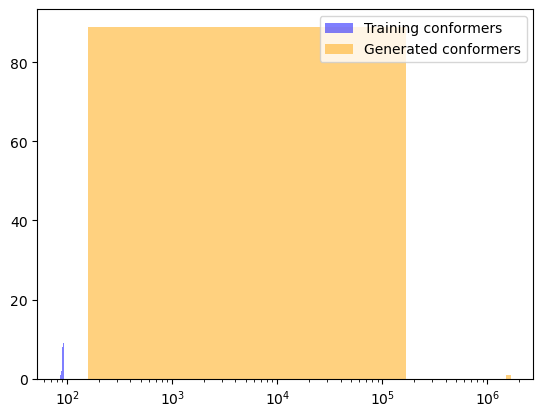

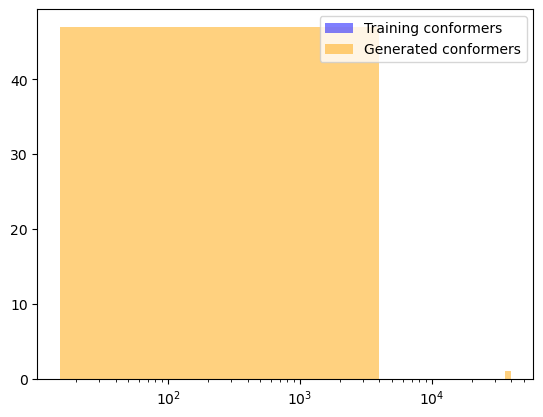

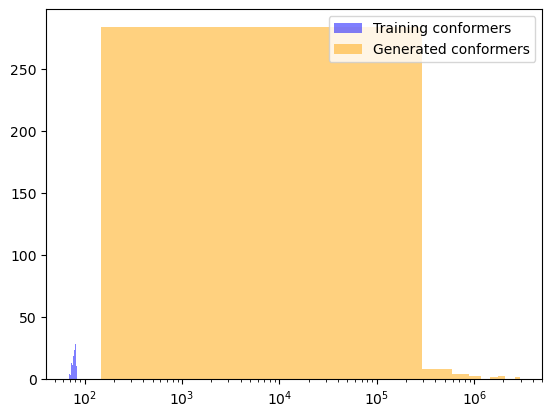

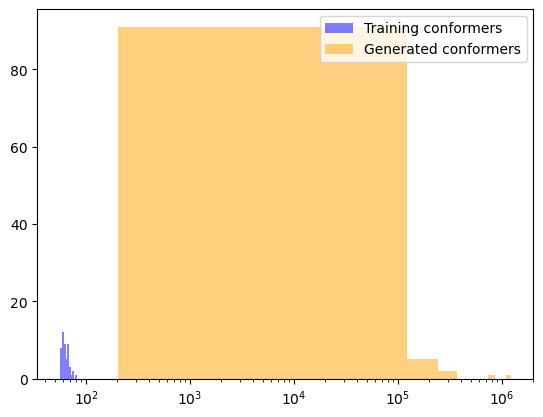

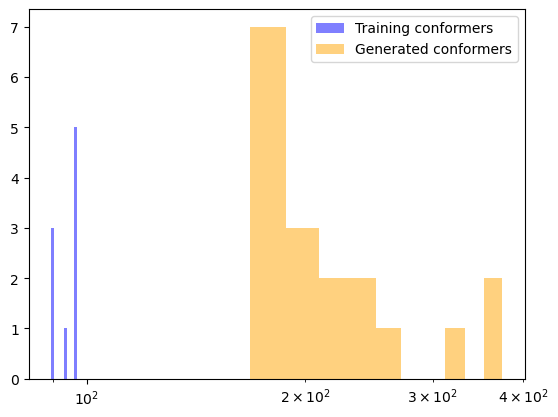

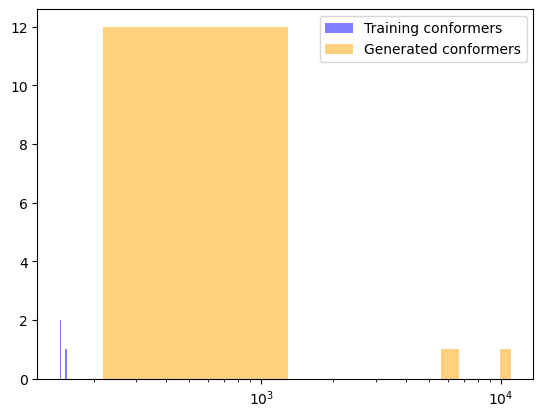

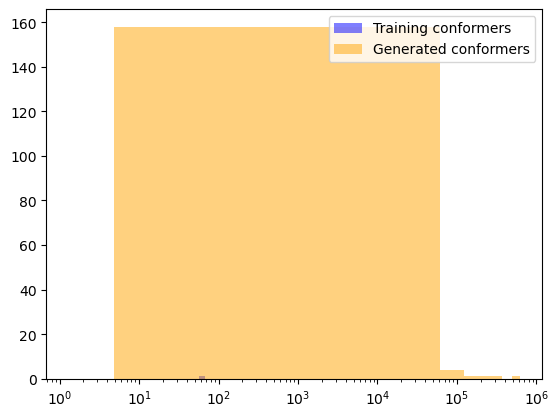

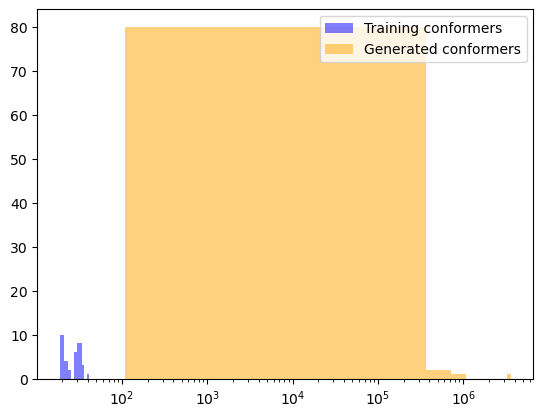

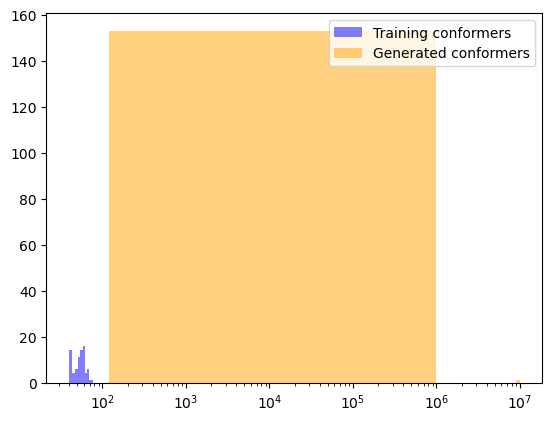

In [10]:
for smi in smis[1:10]:
    mmff_energies = []
    mmff_energies_generated = []
    for i in range(len(training_confs[smi])):
        mmff_energies.append(mmff_energy(training_confs[smi][i]))
    for i in range(len(generated_confs[smi])):
        mmff_energies_generated.append(mmff_energy(generated_confs[smi][i]))
    plt.figure()
    plt.hist(mmff_energies, bins=10, color='blue', alpha=0.5, label='Training conformers')
    plt.hist(mmff_energies_generated, bins=10, color='orange', alpha=0.5, label='Generated conformers')
    plt.legend()
    plt.xscale('log')
    #plt.title(f'{len(conformers)} conformers')

In [23]:
from utils.xtb import *
path_xtb ="/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/xtb"
mol = training_confs[smi][6]
xtb_energy(mol, dipole=True, path_xtb=path_xtb)

xtb_energy did not converge


{}

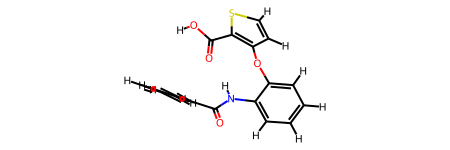

In [33]:
training_confs[smi][7]

In [ ]:
for smi in smis[1:10]:
    mmff_energies = []
    mmff_energies_generated = []
    for i in range(len(training_confs[smi])):
        mmff_energies.append(mmff_energy(training_confs[smi][i]))
    for i in range(len(generated_confs[smi])):
        mmff_energies_generated.append(mmff_energy(generated_confs[smi][i]))
    plt.figure()
    plt.hist(mmff_energies, bins=10, color='blue', alpha=0.5, label='Training conformers')
    plt.hist(mmff_energies_generated, bins=10, color='orange', alpha=0.5, label='Generated conformers')
    plt.legend()
    plt.xscale('log')
    #plt.title(f'{len(conformers)} conformers')